# 性能テストの分析

### おまじない： Py4Jを使ってJavaのプロセスを起動


In [1]:
# Py4Jを使ってJavaのプロセスを起動
import subprocess
import time
sp = subprocess.Popen(
    'java -cp /Library/Java/JavaVirtualMachines/jdk1.8.0_101.jdk/Contents/Home/db/lib/derby.jar'
    + ':$HOME/.pyenv/versions/3.5.2/envs/vistest/share/py4j/py4j0.10.4.jar'
    + ' py4j.GatewayServer 25333',
    shell=True)
time.sleep(1)

In [2]:
# Initializes Java gateway to use Java code from Python program.
from py4j.java_gateway import JavaGateway
gateway = JavaGateway()

### データ操作処理のベンチマーク例

In [3]:
gateway.jvm.java.lang.Class.forName('org.apache.derby.jdbc.EmbeddedDriver').newInstance();
con = gateway.jvm.java.sql.DriverManager.getConnection('jdbc:derby:bench;create=true')

In [4]:
statement = con.createStatement()
statement.execute("""
create table t1 (
  id int primary key,
  info char(254)
)""")

False

In [5]:
insert_ps = con.prepareStatement("insert into t1 values(?, 'sample')")
delete_ps = con.prepareStatement("delete from t1 where id = ?")

In [6]:
# おまじない
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### ベンチマーク用の処理を定義

In [7]:
def benchmark(prepared, i):
    prepared.setInt(1, i)  

    # 処理時間を計測
    start = time.time()
    prepared.execute()
    con.commit()
    end = time.time()
    
    return (end - start) * 1000  # convert to milliseconds

### ベンチマーク処理を実行、結果をファイルに書き出し

In [8]:
with open('bench/insert.log', 'w') as log:
    for i in range(0, 100):
        t = benchmark(insert_ps, i)
        log.write('insert time = {0} [ms]\n'.format(t))

with open('bench/delete.log', 'w') as log:
    for i in range(0, 100):
        t = benchmark(delete_ps, i)
        log.write('delete time = {0} [ms]\n'.format(t))

### ファイルの中身を確認

In [9]:
!head -n 3 bench/insert.log

insert time = 2.4261474609375 [ms]
insert time = 3.1859874725341797 [ms]
insert time = 2.785921096801758 [ms]


In [10]:
!head -n 3 bench/delete.log

delete time = 2.4878978729248047 [ms]
delete time = 1.416921615600586 [ms]
delete time = 1.7201900482177734 [ms]


### 数値を抽出してグラフ化

In [11]:
import parse

with open('bench/insert.log') as log:
    insert_times = [parse.parse('insert time = {0} [ms]\n', line) for line in log]
    insert_times = map(lambda e: float(e[0]), insert_times)

with open('bench/delete.log') as log:
    delete_times = [parse.parse('delete time = {0} [ms]\n', line) for line in log]
    delete_times = map(lambda e: float(e[0]), delete_times)

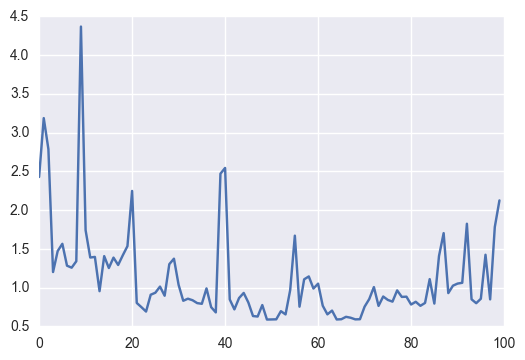

In [12]:
results = np.array(list(insert_times))
plt.plot([i for i in range(0, 100)], results)
plt.show()

In [13]:
data = np.array(results)

In [14]:
stats = {
    '平均': data.mean(),
    'min': data.min(),
    'max': data.max(),
    '50 percentile': np.percentile(data, 50),
    '90 percentile': np.percentile(data, 90),
    '99 percentile': np.percentile(data, 99),
    '分散': data.var(),
    '標準偏差': np.std(data)
}
stats

{'50 percentile': 0.90050697326660156,
 '90 percentile': 1.7440795898437502,
 '99 percentile': 3.1977987289428769,
 'max': 4.3671131134033203,
 'min': 0.58698654174804688,
 '分散': 0.36312553594939345,
 '平均': 1.121828556060791,
 '標準偏差': 0.60259898435808323}

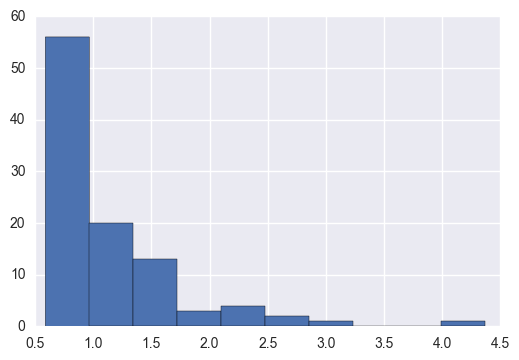

In [15]:
plt.hist(results)
plt.show()

In [16]:
sp.terminate()

In [17]:
!rm -rf bench